In [ ]:
# Import necessary libraries
import os
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout
from sklearn.preprocessing import MinMaxScaler

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!ls /content/drive/MyDrive/final_project_deep_learning/nasdaq_dataset/data_nasdaq_csv/csv

AAL.csv    BDMS.csv   CPRT.csv	 FATE.csv   HOLI.csv	LQDT.csv   OIIM.csv   RMCF.csv	 TCFC.csv
AAME.csv   BDSI.csv   CPRX.csv	 FBIZ.csv   HOLX.csv	LRCX.csv   OIS.csv    RMGN.csv	 TCPC.csv
AAOI.csv   BEAT.csv   CPSI.csv	 FBMS.csv   HOV.csv	LSBK.csv   OKE.csv    RMTI.csv	 TCX.csv
AAON.csv   BEBE.csv   CPSS.csv	 FBP.csv    HQCL.csv	LSCC.csv   OLED.csv   RNST.csv	 TEDU.csv
AAPL.csv   BECN.csv   CRAI.csv	 FCAP.csv   HQY.csv	LSTR.csv   OMAB.csv   RNWK.csv	 TEI.csv
AAVL.csv   BELFB.csv  CREG.csv	 FCBC.csv   HRTX.csv	LTBR.csv   OMCL.csv   ROCK.csv	 TENX.csv
AAWW.csv   BFIN.csv   CRIS.csv	 FCCO.csv   HRZN.csv	LTRE.csv   OMER.csv   ROIC.csv	 TESS.csv
ABCB.csv   BGCP.csv   CRMT.csv	 FCEL.csv   HSIC.csv	LTRPA.csv  OMEX.csv   ROST.csv	 TGA.csv
ABCD.csv   BGFV.csv   CRNT.csv	 FCMGF.csv  HSII.csv	LTRX.csv   OMF.csv    ROYL.csv	 TGEN.csv
ABCO.csv   BGMD.csv   CROX.csv	 FCNCA.csv  HSKA.csv	LULU.csv   OMRNY.csv  RPRX.csv	 TGLS.csv
ABIO.csv   BIDU.csv   CRTN.csv	 FCT.csv    HSON.csv	LUNA.csv   ONB.csv    R

In [ ]:
# Set the paths for your project
csv_path = '/content/drive/MyDrive/final_project_deep_learning/nasdaq_dataset/data_nasdaq_csv/csv'

In [ ]:
stock_symbols_dictionary_path = '/content/drive/MyDrive/final_project_deep_learning/stock_symbols_dictionary.csv'

# Load the CSV file containing company symbols and data
stock_symbols_dictionary_df = pd.read_csv(stock_symbols_dictionary_path)

# Convert 'Market Cap' to numeric, handling errors
stock_symbols_dictionary_df['Market Cap'] = pd.to_numeric(stock_symbols_dictionary_df['Market Cap'], errors='coerce')

# Drop rows with NaN values in the 'Market Cap' column
stock_symbols_dictionary_df = stock_symbols_dictionary_df.dropna(subset=['Market Cap'])

In [ ]:
# Filter for companies in the Technology sector
technology_df = stock_symbols_dictionary_df[stock_symbols_dictionary_df['Sector'] == 'Technology']

# Sort the DataFrame by 'Market Cap' in descending order
sorted_technology_df = technology_df.sort_values(by='Market Cap', ascending=False)

# Get the top 30 company symbols
top_30_technology_symbols = sorted_technology_df['Symbol'].head(30).tolist()
top_30_technology_symbols = [symbol.strip().upper() for symbol in top_30_technology_symbols]

# List all CSV files in the specified folder
all_csv_files = [f for f in os.listdir(csv_path) if f.endswith('.csv')]

# Select files that match the top 30 technology symbols
selected_top_30_technology_files = [
    f for f in all_csv_files if os.path.splitext(f)[0].strip().upper() in top_30_technology_symbols
]

# Display the selected files
print("\nSelected CSV files for the top 30 technology symbols:")
print(selected_top_30_technology_files)
print(f"\nTotal number of selected files: {len(selected_top_30_technology_files)}")


Selected CSV files for the top 30 technology symbols:
['MSFT.csv', 'AMAT.csv', 'AMD.csv', 'NXPI.csv', 'NVDA.csv', 'TYL.csv', 'MRVL.csv', 'MPWR.csv', 'PAYX.csv', 'SNPS.csv', 'ADP.csv', 'ON.csv', 'QCOM.csv', 'AAPL.csv', 'GRMN.csv', 'CTSH.csv', 'MU.csv', 'ASML.csv', 'LRCX.csv', 'CSCO.csv', 'MCHP.csv', 'CDNS.csv', 'MSTR.csv', 'ADI.csv', 'ADBE.csv', 'INTU.csv', 'INTC.csv', 'TXN.csv', 'FTNT.csv', 'ADSK.csv']

Total number of selected files: 30


In [ ]:
# Load selected CSV files and create a list to store dataframes
df_list = []
for file in selected_top_30_technology_files:
    file_path = os.path.join(csv_path, file)
    data = pd.read_csv(file_path, on_bad_lines='skip')
    df_list.append(data)

In [ ]:
for data in df_list:
        data['Date'] = pd.to_datetime(data['Date'], dayfirst=True, errors='coerce')

In [ ]:
split_date_train = pd.Timestamp('01-01-2020')
split_date_val = pd.Timestamp('01-01-2021')

In [ ]:
df_train_list = []
df_val_list = []
df_test_list = []
for i in range(30):
    cur_df = df_list[i]
    df_train = cur_df.loc[cur_df['Date'] < split_date_train] # Split training
    df_test = cur_df.loc[cur_df['Date'] >= split_date_train] # Split testing
    df_train_list.append(df_train)
    df_test_list.append(df_test)

for i in range(30):
    cur_test_df = df_test_list[i]
    df_test = cur_test_df.loc[cur_test_df['Date'] >= split_date_val] # Split testing
    df_val = cur_test_df.loc[cur_test_df['Date'] < split_date_val] # Split validation
    df_test_list[i] = df_test
    df_val_list.append(df_val)

In [ ]:
# Function to normalize data with Min-Max scaling
def min_max_normalize(X_data, y_data=None):
    print("Normalizing data with Min-Max scaling...")
    X_norm = X_data.copy()
    y_norm = y_data.copy() if y_data is not None else None

    for i in range(len(X_data)):
        for j in range(X_data.shape[2]):
            min_feature = np.min(X_data[i][:, j])
            max_feature = np.max(X_data[i][:, j])
            X_norm[i][:, j] = (X_data[i][:, j] - min_feature) / (max_feature - min_feature) if max_feature > min_feature else 0
        if (i+1) % 100 == 0 or i == len(X_data) - 1:  # Print progress every 100 samples
            print(f"Processed normalization for sample {i+1}/{len(X_data)}")

    if y_data is not None:
        for i in range(len(y_data)):
            min_label = np.min(X_data[i][:, 1])
            max_label = np.max(X_data[i][:, 1])
            y_norm[i] = (y_data[i] - min_label) / (max_label - min_label) if max_label > min_label else 0

    print("Normalization complete.")
    return X_norm, y_norm

In [ ]:
from tqdm import tqdm
import numpy as np

# Function to split a dataset into time windows with tqdm progress bar
def create_time_window_samples_k_days(df_list, window_size=30, predict_ahead=3):
    X_data_k_days = []
    y_data_k_days = []

    # Wrap tqdm around the main loop to track progress
    for df in tqdm(df_list, desc="Processing DataFrames"):
        # Adjust the loop to stop before the last few rows which cannot form a full window plus the prediction window
        for i in range(0, len(df) - window_size - predict_ahead + 1):
            current_feature = []

            # Get a window_size time frame for data features
            for j in range(window_size):
                # Concatenate all 5 features (excluding target 'Open' in this case)
                data_feature = [df.iloc[i + j, k] for k in range(1, 6)]
                current_feature.append(np.array(data_feature))

            # Collect the 'Open' prices for k consecutive days after the last day in the window
            data_label = [df.iloc[i + window_size + d, 2] for d in range(predict_ahead)]  # 'Open' is at index 2

            # Append new data sample (feature and label) to X_data and y_data
            X_data_k_days.append(np.array(current_feature).reshape(window_size, 5))
            y_data_k_days.append(np.array(data_label))

    return np.array(X_data_k_days), np.array(y_data_k_days)

# Define the window size and days ahead to predict
window_size = 30
k = 3  # Change this to the number of consecutive days you want to predict

# Generate training, validation, and test samples for k consecutive days
X_train_k_days, y_train_k_days = create_time_window_samples_k_days(df_train_list, window_size, k)
X_val_k_days, y_val_k_days = create_time_window_samples_k_days(df_val_list, window_size, k)
X_test_k_days, y_test_k_days = create_time_window_samples_k_days(df_test_list, window_size, k)

# Normalize the data
X_train_k_days_norm, y_train_k_days_norm = min_max_normalize(X_train_k_days, y_train_k_days)
X_val_k_days_norm, y_val_k_days_norm = min_max_normalize(X_val_k_days, y_val_k_days)
X_test_k_days_norm, y_test_k_days_norm = min_max_normalize(X_test_k_days, y_test_k_days)

Processing DataFrames: 100%|██████████| 30/30 [00:42<00:00,  1.42s/it]


Normalizing data with Min-Max scaling...
Processed normalization for sample 100/222885
Processed normalization for sample 200/222885
Processed normalization for sample 300/222885
Processed normalization for sample 400/222885
Processed normalization for sample 500/222885
Processed normalization for sample 600/222885
Processed normalization for sample 700/222885
Processed normalization for sample 800/222885
Processed normalization for sample 900/222885
Processed normalization for sample 1000/222885
Processed normalization for sample 1100/222885
Processed normalization for sample 1200/222885
Processed normalization for sample 1300/222885
Processed normalization for sample 1400/222885
Processed normalization for sample 1500/222885
Processed normalization for sample 1600/222885
Processed normalization for sample 1700/222885
Processed normalization for sample 1800/222885
Processed normalization for sample 1900/222885
Processed normalization for sample 2000/222885
Processed normalization for 

In [ ]:
# Import libraries
import tensorflow as tf
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, BatchNormalization, Dropout, AveragePooling1D

# Build the model architecture
model = tf.keras.Sequential()
model.add(Conv1D(32, kernel_size=3, activation='relu', input_shape=(window_size, 5), padding='same'))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(32, kernel_size=3, activation='relu', padding='same'))
model.add(MaxPooling1D(2))
model.add(Conv1D(32, kernel_size=3, activation='relu', padding='same'))
model.add(MaxPooling1D(2))
model.add(Conv1D(32, kernel_size=3, activation='relu', padding='same'))
model.add(MaxPooling1D(2))
model.add(Flatten())
model.add(Dense(100, activation='relu'))
model.add(Dense(3))

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [24]:
# Compile and train the model with Mean Squared Error loss function
model.summary()
model.compile(optimizer= tf.keras.optimizers.Adam(learning_rate=0.01), loss='mse', metrics=['mse'])
history = model.fit(X_train_k_days_norm, y_train_k_days_norm, validation_data=(X_val_k_days_norm,y_val_k_days_norm), epochs=20, batch_size=2048, verbose=1)

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                      │ (None, 30, 32)              │             512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d (MaxPooling1D)         │ (None, 15, 32)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_1 (Conv1D)                    │ (None, 15, 32)              │           3,104 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_1 (MaxPooling1D)       │ (None, 7, 32)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_2 (Conv1D)                    │ (None, 7, 32)               │           3,104 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_2 (MaxPooling1D)       │ (None, 3, 32)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_3 (Conv1D)                    │ (None, 3, 32)               │           3,104 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_3 (MaxPooling1D)       │ (None, 1, 32)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 100)                 │           3,300 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 3)                   │             303 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 40,283 (157.36 KB)

 Trainable params: 13,427 (52.45 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 26,856 (104.91 KB)

Epoch 1/20
109/109 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - loss: 0.0515 - mse: 0.0515 - val_loss: 0.0430 - val_mse: 0.0430
Epoch 2/20
109/109 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0375 - mse: 0.0375 - val_loss: 0.0431 - val_mse: 0.0431
Epoch 3/20
109/109 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0382 - mse: 0.0382 - val_loss: 0.0433 - val_mse: 0.0433
Epoch 4/20
109/109 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0378 - mse: 0.0378 - val_loss: 0.0425 - val_mse: 0.0425
Epoch 5/20
109/109 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0377 - mse: 0.0377 - val_loss: 0.0424 - val_mse: 0.0424
Epoch 6/20
109/109 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0376 - mse: 0.0376 - val_loss: 0.0434 - val_mse: 0.0434
Epoch 7/20
109/109 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0377 - mse: 0.0377 - val_loss: 0.0427 - val_mse: 0.0427
Epoch 8/20
109/109 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0386 - mse: 0.0386 - val_loss: 0.0425 - val_mse: 0.0425
Epoch 9/20
109/109 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - l

In [ ]:
from tensorflow.keras.layers import LSTM, Flatten, Dense

# Build the LSTM model architecture
modelLSTM = tf.keras.Sequential()
modelLSTM.add(LSTM(50, return_sequences=True, input_shape=(window_size, 5)))  # First LSTM layer with 50 units
modelLSTM.add(Dropout(0.2))  # Dropout layer for regularization
modelLSTM.add(LSTM(50, return_sequences=False))  # Second LSTM layer with 50 units
modelLSTM.add(Dropout(0.2))  # Another Dropout layer for regularization
modelLSTM.add(Dense(100, activation='relu'))  # Dense layer with 100 units and ReLU activation
modelLSTM.add(Dense(3))  # Output layer for regression (predicting stock prices)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
# Compile the model
modelLSTM.summary()
modelLSTM.compile(optimizer= tf.keras.optimizers.Adam(learning_rate=0.01), loss='mse', metrics=['mse'])
history = modelLSTM.fit(X_train_k_days_norm, y_train_k_days_norm, validation_data=(X_val_k_days_norm,y_val_k_days_norm), epochs=20, batch_size=2048, verbose=1)

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 30, 50)              │          11,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 30, 50)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 50)                  │          20,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 50)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 100)                 │           5,100 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 3)                   │             303 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 36,803 (143.76 KB)

 Trainable params: 36,803 (143.76 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
109/109 ━━━━━━━━━━━━━━━━━━━━ 75s 652ms/step - loss: 0.1589 - mse: 0.1589 - val_loss: 0.0438 - val_mse: 0.0438
Epoch 2/20
109/109 ━━━━━━━━━━━━━━━━━━━━ 84s 669ms/step - loss: 0.0435 - mse: 0.0435 - val_loss: 0.0430 - val_mse: 0.0430
Epoch 3/20
109/109 ━━━━━━━━━━━━━━━━━━━━ 78s 634ms/step - loss: 0.0417 - mse: 0.0417 - val_loss: 0.0429 - val_mse: 0.0429
Epoch 4/20
109/109 ━━━━━━━━━━━━━━━━━━━━ 86s 667ms/step - loss: 0.0411 - mse: 0.0411 - val_loss: 0.0429 - val_mse: 0.0429
Epoch 5/20
109/109 ━━━━━━━━━━━━━━━━━━━━ 77s 630ms/step - loss: 0.0416 - mse: 0.0416 - val_loss: 0.0426 - val_mse: 0.0426
Epoch 6/20
109/109 ━━━━━━━━━━━━━━━━━━━━ 82s 633ms/step - loss: 0.0404 - mse: 0.0404 - val_loss: 0.0434 - val_mse: 0.0434
Epoch 7/20
109/109 ━━━━━━━━━━━━━━━━━━━━ 67s 618ms/step - loss: 0.0397 - mse: 0.0397 - val_loss: 0.0435 - val_mse: 0.0435
Epoch 8/20
109/109 ━━━━━━━━━━━━━━━━━━━━ 83s 621ms/step - loss: 0.0393 - mse: 0.0393 - val_loss: 0.0438 - val_mse: 0.0438
Epoch 9/20
109/109 ━━━━━━━━━━━━━

In [ ]:
# Build the GRU model architecture
modelGRU = tf.keras.Sequential()
modelGRU.add(tf.keras.layers.GRU(64, return_sequences=True, input_shape=(window_size, 5)))  # First GRU layer with 64 units
modelGRU.add(tf.keras.layers.Dropout(0.2))  # Dropout layer for regularization
modelGRU.add(tf.keras.layers.GRU(64, return_sequences=False))  # Second GRU layer with 64 units
modelGRU.add(tf.keras.layers.Dropout(0.2))  # Another Dropout layer for regularization
modelGRU.add(tf.keras.layers.Dense(100, activation='relu'))  # Dense layer with 100 units and ReLU activation
modelGRU.add(tf.keras.layers.Dense(3))  # Output layer for regression (predicting stock prices)

In [ ]:
# Compile the model
modelGRU.summary()
modelGRU.compile(optimizer= tf.keras.optimizers.Adam(learning_rate=0.01), loss='mse', metrics=['mse'])
history = modelGRU.fit(X_train_k_days_norm, y_train_k_days_norm, validation_data=(X_val_k_days_norm,y_val_k_days_norm), epochs=20, batch_size=2048, verbose=1)

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ gru (GRU)                            │ (None, 30, 64)              │          13,632 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 30, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_1 (GRU)                          │ (None, 64)                  │          24,960 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 100)                 │           6,500 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 3)                   │             303 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 45,395 (177.32 KB)

 Trainable params: 45,395 (177.32 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
109/109 ━━━━━━━━━━━━━━━━━━━━ 111s 969ms/step - loss: 0.1332 - mse: 0.1332 - val_loss: 0.0437 - val_mse: 0.0437
Epoch 2/20
109/109 ━━━━━━━━━━━━━━━━━━━━ 102s 927ms/step - loss: 0.0422 - mse: 0.0422 - val_loss: 0.0428 - val_mse: 0.0428
Epoch 3/20
109/109 ━━━━━━━━━━━━━━━━━━━━ 142s 926ms/step - loss: 0.0410 - mse: 0.0410 - val_loss: 0.0425 - val_mse: 0.0425
Epoch 4/20
109/109 ━━━━━━━━━━━━━━━━━━━━ 141s 924ms/step - loss: 0.0398 - mse: 0.0398 - val_loss: 0.0424 - val_mse: 0.0424
Epoch 5/20
109/109 ━━━━━━━━━━━━━━━━━━━━ 103s 942ms/step - loss: 0.0400 - mse: 0.0400 - val_loss: 0.0429 - val_mse: 0.0429
Epoch 6/20
109/109 ━━━━━━━━━━━━━━━━━━━━ 141s 936ms/step - loss: 0.0397 - mse: 0.0397 - val_loss: 0.0422 - val_mse: 0.0422
Epoch 7/20
109/109 ━━━━━━━━━━━━━━━━━━━━ 142s 935ms/step - loss: 0.0390 - mse: 0.0390 - val_loss: 0.0434 - val_mse: 0.0434
Epoch 8/20
109/109 ━━━━━━━━━━━━━━━━━━━━ 141s 928ms/step - loss: 0.0389 - mse: 0.0389 - val_loss: 0.0421 - val_mse: 0.0421
Epoch 9/20
109/109 ━━━━━

In [ ]:
# Evaluate the models on the test set
loss_Conv1D, mse_Conv1D = model.evaluate(X_test_k_days_norm, y_test_k_days_norm, verbose=0)
loss_LSTM, mse_LSTM = modelLSTM.evaluate(X_test_k_days_norm, y_test_k_days_norm, verbose=0)
loss_GRU, mse_GRU = modelGRU.evaluate(X_test_k_days_norm, y_test_k_days_norm, verbose=0)

# Print the evaluation results
print(f'Conv1D Model - Test loss: {loss_Conv1D:.3f}, Test MSE: {mse_Conv1D:.3f}')
print(f'LSTM Model - Test loss: {loss_LSTM:.3f}, Test MSE: {mse_LSTM:.3f}')
print(f'GRU Model - Test loss: {loss_GRU:.3f}, Test MSE: {mse_GRU:.3f}')

Conv1D Model - Test loss: 0.036, Test MSE: 0.036
LSTM Model - Test loss: 0.040, Test MSE: 0.040
GRU Model - Test loss: 0.037, Test MSE: 0.037


430/430 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
430/430 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
430/430 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


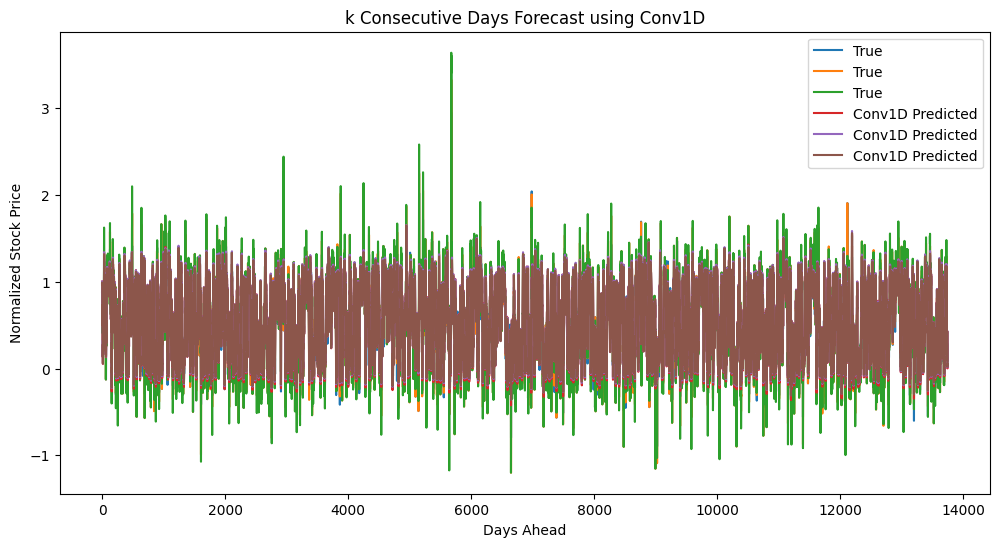

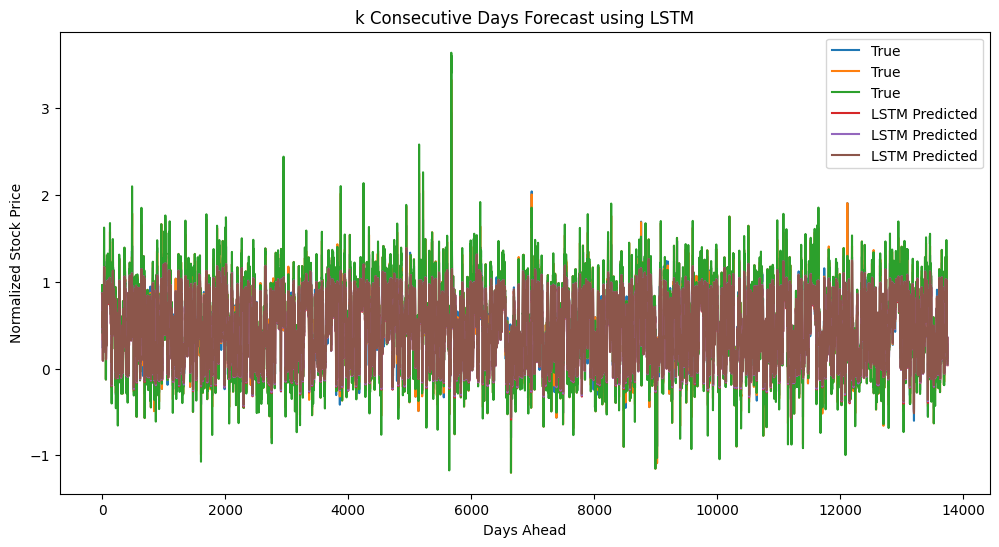

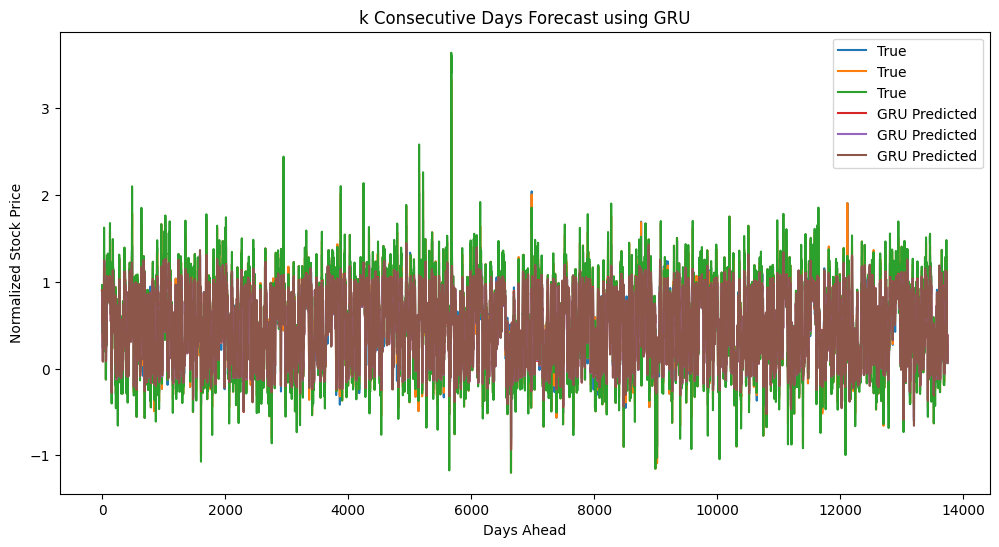

In [ ]:
import matplotlib.pyplot as plt

# Make predictions with each model
yhat_Conv1D = model.predict(X_test_k_days_norm)
yhat_LSTM = modelLSTM.predict(X_test_k_days_norm)
yhat_GRU = modelGRU.predict(X_test_k_days_norm)

# Plot the true vs. predicted stock prices for k consecutive days
# Conv1D Model
plt.figure(figsize=(12, 6))
plt.plot(y_test_k_days_norm, label='True')
plt.plot(yhat_Conv1D, label='Conv1D Predicted')
plt.title('k Consecutive Days Forecast using Conv1D')
plt.xlabel('Days Ahead')
plt.ylabel('Normalized Stock Price')
plt.legend()
plt.show()

# LSTM Model
plt.figure(figsize=(12, 6))
plt.plot(y_test_k_days_norm, label='True')
plt.plot(yhat_LSTM, label='LSTM Predicted')
plt.title('k Consecutive Days Forecast using LSTM')
plt.xlabel('Days Ahead')
plt.ylabel('Normalized Stock Price')
plt.legend()
plt.show()

# GRU Model
plt.figure(figsize=(12, 6))
plt.plot(y_test_k_days_norm, label='True')
plt.plot(yhat_GRU, label='GRU Predicted')
plt.title('k Consecutive Days Forecast using GRU')
plt.xlabel('Days Ahead')
plt.ylabel('Normalized Stock Price')
plt.legend()
plt.show()

Using modelGRU for prediction
Randomly selected company file: TYL.csv
430/430 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


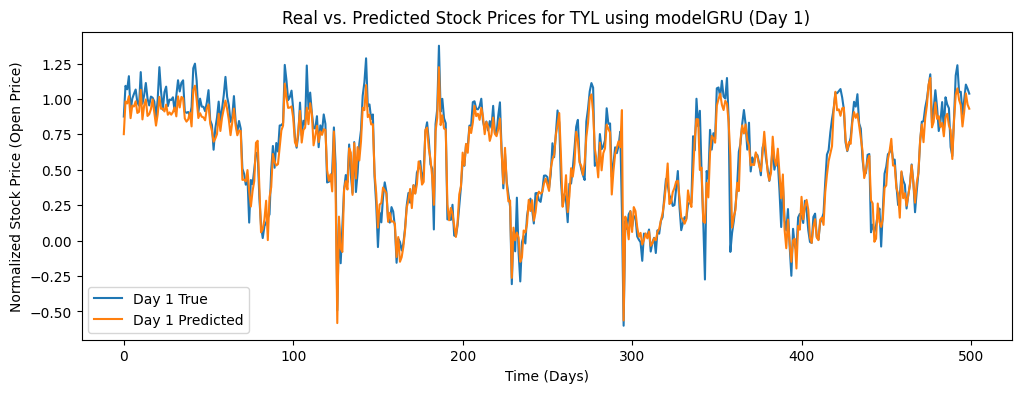

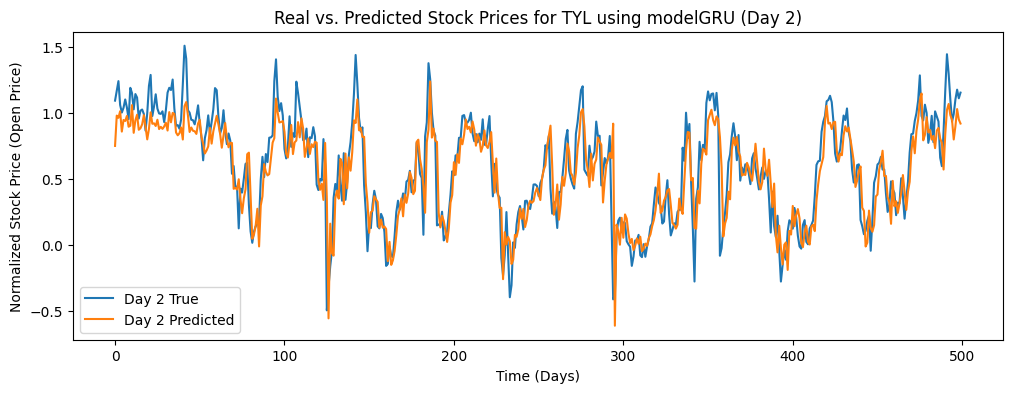

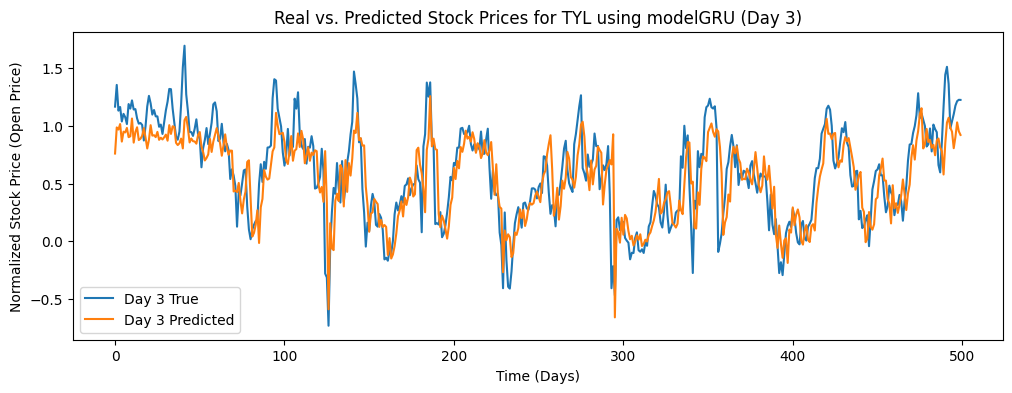

In [ ]:
import random
import matplotlib.pyplot as plt

# Dictionary of models
models = {
    "modelConv1D": model,
    "modelLSTM": modelLSTM,
    "modelGRU": modelGRU
}

# Randomly select a model for prediction
selected_model_name = random.choice(list(models.keys()))
selected_model = models[selected_model_name]
print(f"Using {selected_model_name} for prediction")

# Randomly select a company file from the list of top 30 technology symbols
random_company_index = random.randint(0, len(selected_top_30_technology_files) - 1)
random_file = selected_top_30_technology_files[random_company_index]
print(f"Randomly selected company file: {random_file}")

# Make predictions with the selected model for the k-day forecast
yhat_k_days = selected_model.predict(X_test_k_days_norm)

# Select a random starting index for the 500-day subset
random_index = random.randint(0, len(y_test_k_days_norm) - 500)

# Loop through each of the 3 days and create a separate plot
for day in range(3):
    plt.figure(figsize=(12, 4))
    plt.plot(y_test_k_days_norm[random_index:random_index + 500, day], label=f'Day {day + 1} True')
    plt.plot(yhat_k_days[random_index:random_index + 500, day], label=f'Day {day + 1} Predicted')
    plt.title(f"Real vs. Predicted Stock Prices for {random_file.split('.')[0]} using {selected_model_name} (Day {day + 1})")
    plt.xlabel("Time (Days)")
    plt.ylabel("Normalized Stock Price (Open Price)")
    plt.legend()
    plt.show()